# Threshold-Based Segmentation

Our first step in the segmentation process is to separate the foreground of the mammogram containing the breast region of interest (ROI) from the background.  The result of this *binarization* process is a binary image or mask that can be used to isolate ROIs, label structures within the image, detect edges and contours, classify abnormalities, and perform other tasks across the image analysis workflow.

This *binarization* of the image can be accomplished using a range of statistical approaches and sophisticated machine-learning classification methods that group pixels of an image into different classes. However, the simplest approach would be to set a pixel value cut-off point, or *threshold*, that separates groups of pixel intensities from each other. From a grayscale mammogram, a binary image or mask is created whereby all pixel values less than or equal to the threshold are set to 0 and all other pixel values are set to 1  [^binary].

[^binary]: WLOG some software packages equivalently set pixel values above the threshold to 255, instead of 1. Converting between these representations can be achieved via normalization of the pixel values.

Image binarization using pixel intensity thresholds is suitable in digital mammography where pixel intensity is the parameter that most directly relates to the spatial characteristics of the structures within a mammogram. Hence, binarization using threshold-based segmentation is often a critical first step in many biomedical image analysis workflows.

The taxonomy of threshold-based segmentation techniques can be roughly characterized as global threshold segmentation and adaptive local threshold segmentation.

## Global Threshold Segmentation

Global threshold segmentation applies a single designated or automatically selected threshold value to the entire image.  Specifically, let $I$ be the input image with height $H$ and width $W$ pixels, and that $I_{x,y}$ represents the gray value of row $x$ and column $y$ of $I$, such that $0 \le x < H, 0 \le y < W$. Then, $B_{x,y}$ represents the binary value in row $x$ and column $y$ of binary mask $B$, and is given by:

```{math}
:label: global_threshold
B_{x,y} = \begin{cases}
1 & if I_{x,y} > T \\
0 & if I_{x,y} \le T \\
\end{cases}
```

where $T$ is a global threshold.

To illustrate, let’s create some binary masks for our test images using a manually set threshold $T=10$.

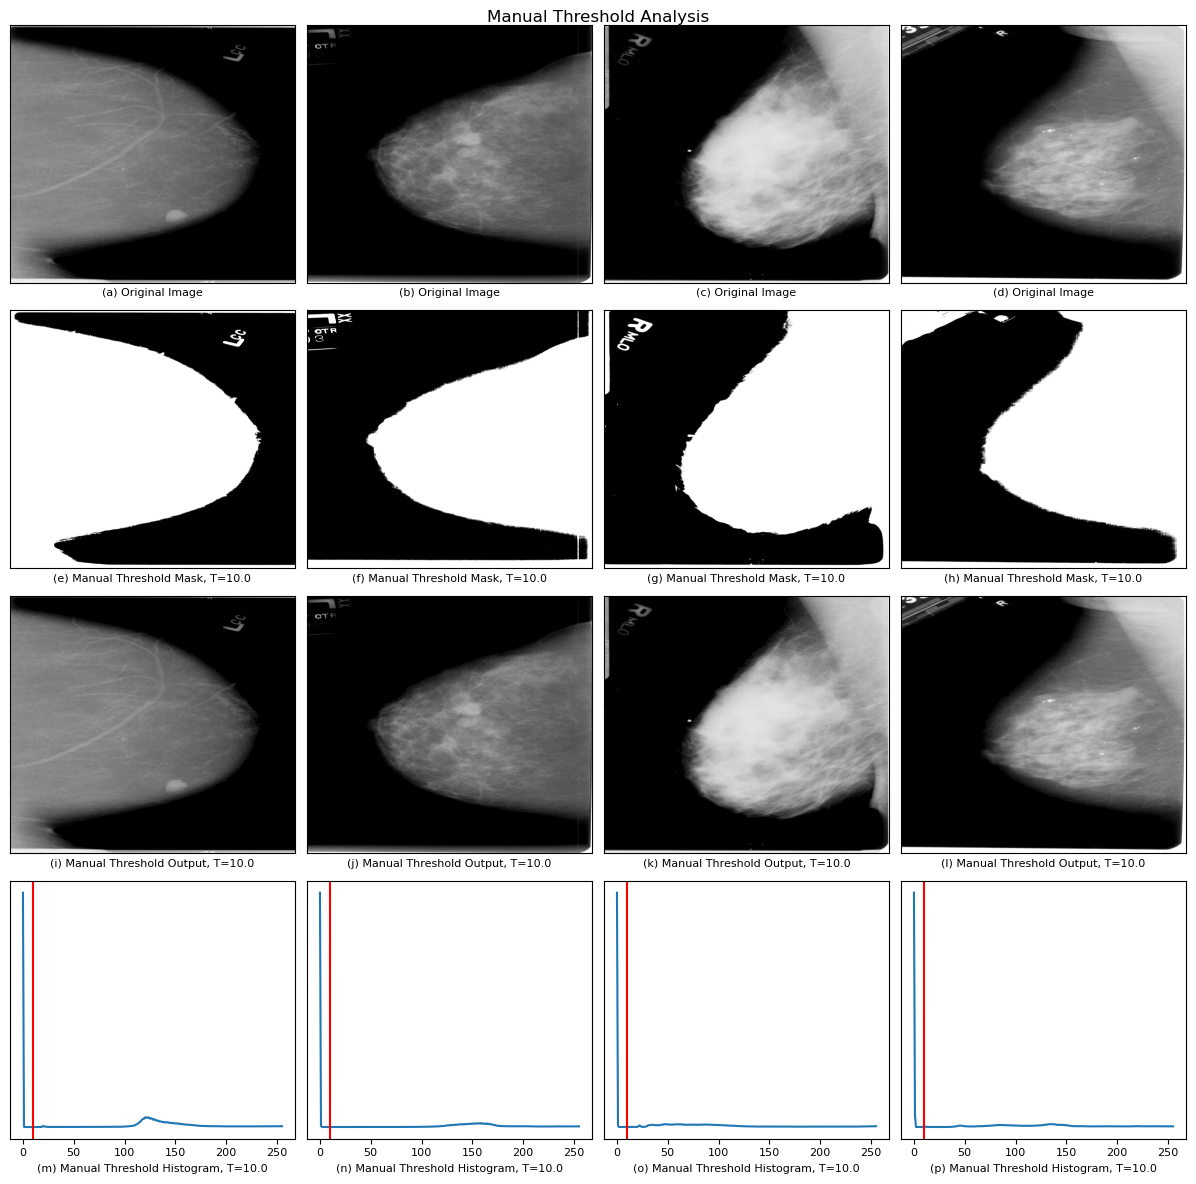

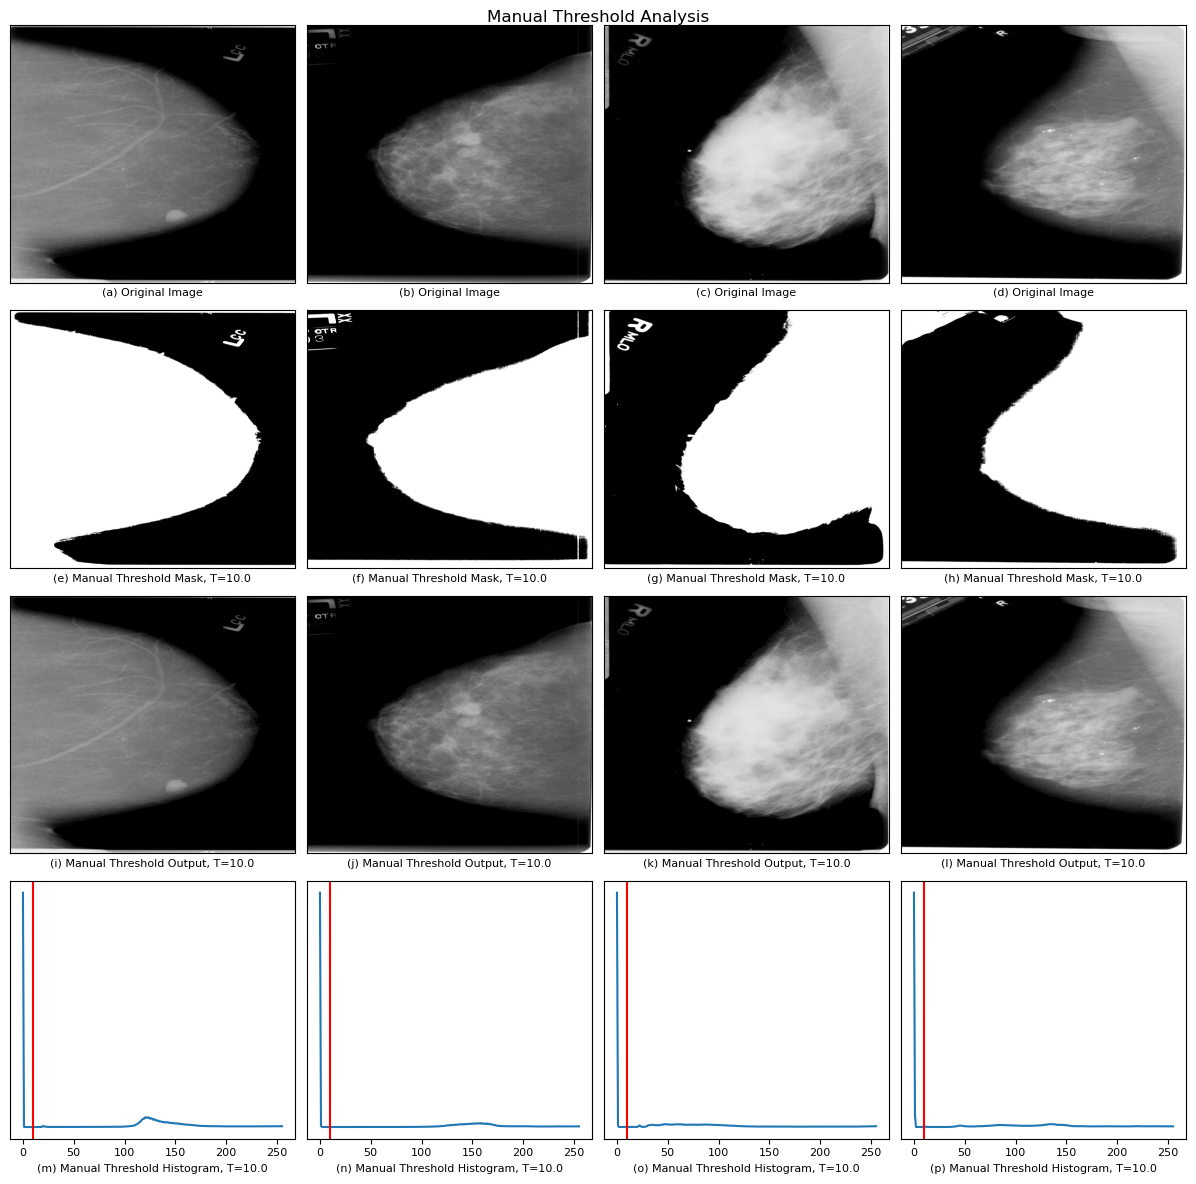

In [1]:
import os
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../../..")))

import numpy as np
import cv2
import matplotlib.pyplot as plt
from myst_nb import glue

from bcd.preprocess.image.threshold import (ThresholdAnalyzer,
    ThresholdLi, ThresholdISOData, ThresholdTriangle, ThresholdOTSU, ThresholdAdaptiveMean, ThresholdAdaptiveGaussian, ThresholdManual
)

img1 = "data/image/1_dev/converted/train/benign/347c2455-cb62-40f8-a173-9e4eb9a21902.png"
img2 = "data/image/1_dev/converted/train/benign/4ed91643-1e06-4b2c-8efb-bc60dd9e0313.png"
img3 = "data/image/1_dev/converted/train/malignant/7dcc12fd-88f0-4048-a6ab-5dd0bd836f08.png"
img4 = "data/image/1_dev/converted/train/malignant/596ef5db-9610-4f13-9c1a-4c411b1d957c.png"

img1 = cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2, cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(img3, cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread(img4, cv2.IMREAD_GRAYSCALE)

images = (img1,img2,img3,img4)

analyzer = ThresholdAnalyzer()
threshold = ThresholdManual(threshold=10)
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_manual_10", fig)

```{glue:figure} threshold_manual_10
---
align: center
name: threshold_manual_10_fig
---
Manual Threshold-Based Segmentation with $T=10$
```

In {numref}`threshold_manual_10_fig`, we have our four randomly selected images, the associated binary masks, and the output images. At threshold $T=10$, we have a clear separation between foreground and background; however, we have little to no artifact suppression.

Let’s examine the effect of increasing the threshold to $T=100$.

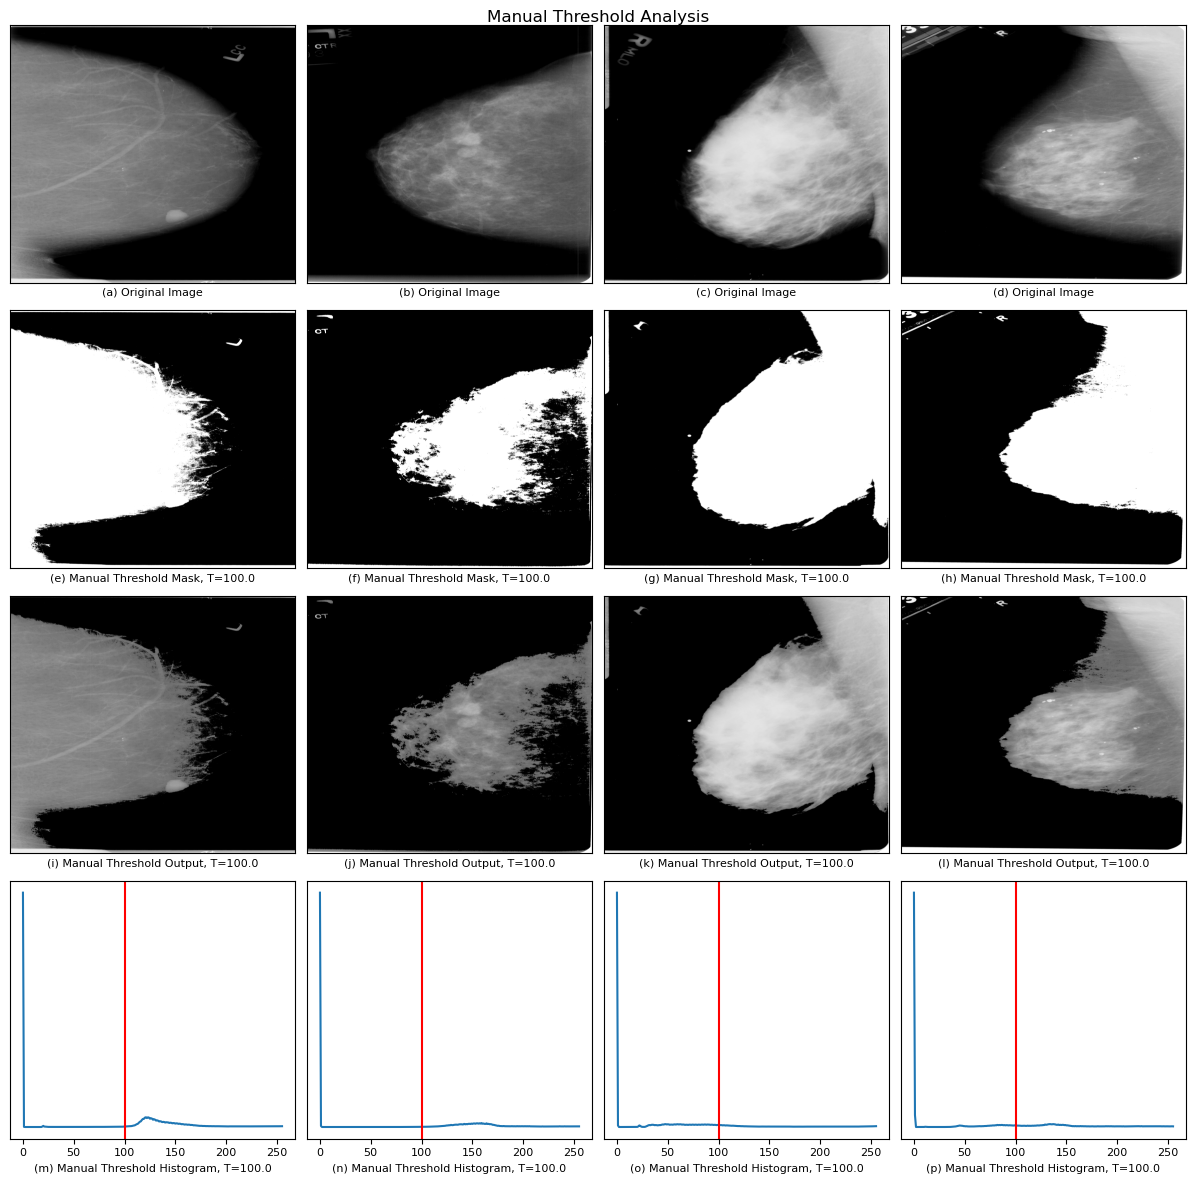

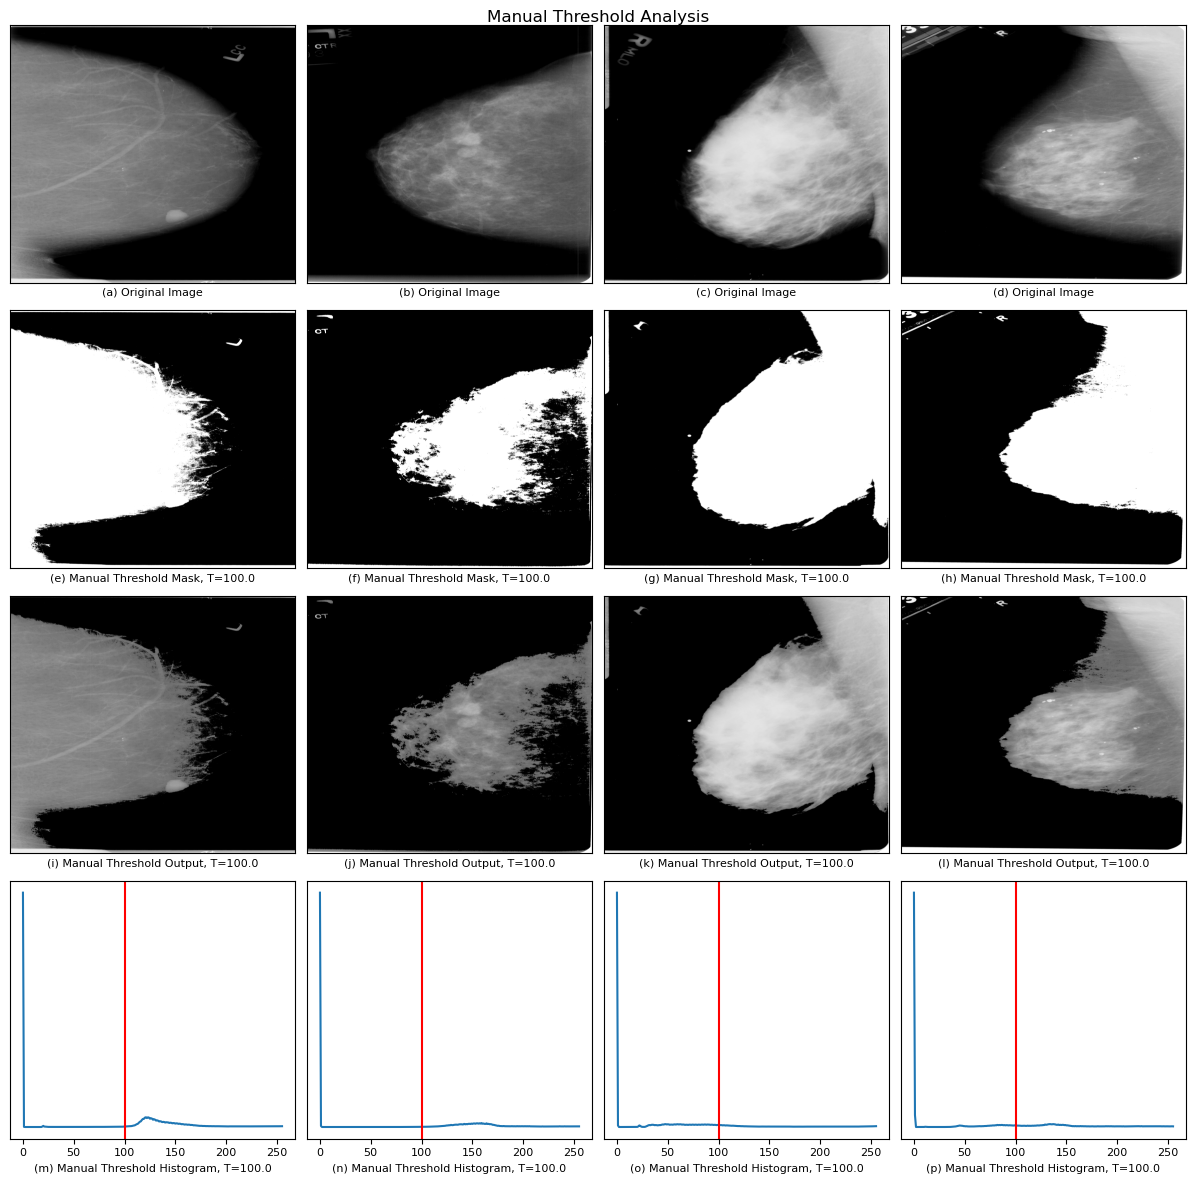

In [2]:
analyzer = ThresholdAnalyzer()
threshold = ThresholdManual(threshold=100)
fig = analyzer.analyze(images=images, threshold=threshold)

glue("threshold_manual_100", fig)

```{glue:figure} threshold_manual_100
---
align: center
name: threshold_manual_100_fig
---
Manual Threshold-Based Segmentation with $T=100$
```

{numref}`threshold_manual_10_fig` and {numref}`threshold_manual_100_fig` illustrate the first key takeaway of this section.

`````{admonition} In threshold segmentation, the choice of threshold is crucial!
:class: tip
Different thresholds may yield dramatically different segmentation results.
`````

A threshold that is too low tends to produce over-segmentation, combining distinct objects into single structures and failing to separate artifacts from regions of interest as shown in {numref}`threshold_manual_10_fig`  (i)-(l). On the other hand, a high threshold can make objects smaller, resulting in loss of information as structures of interest are designated to the background as evidenced in {numref}`threshold_manual_100_fig`  (i)-(l).

So, what are the principled ways by which an appropriate threshold is selected? This leads to our second key takeaway.

`````{admonition} Choosing a threshold manually should be avoided, when possible!
:class: tip
Manual thresholding is inefficient, irreproducible, and a huge source of user bias.
`````

...rant in 3,…2,…

Selecting thresholds manually is tedious, time-consuming, and a huge source of user bias. It is based upon human perception of what information should be extracted from the image, leading to high intra- and inter-user variability; further compounded by the inherent variability in digital mammography. One fixed threshold will not extract similar features from different images. Manual thresholding has little to no reproducibility and it is incompatible with automatic, image-driven thresholding that is based on image-intrinsic properties and not on subjective real-time user decisions.

So, what is the alternative?

## Automated Thresholding

Image processing literature is replete with automatic thresholding algorithms of various types, each based upon a vast array of image-intrinsic properties.  Automated thresholding has several benefits vis-à-vis manual thresholding.

- **Bias-Free Thresholding**: No user bias is introduced during *thresholding*,
- **Objectivity**: Thresholds are objectively determined and image-specific,
- **Reproducibility**: They are reproducible, in that a parameterized algorithm will always produce the same binarization result for a given image,
- **Efficient**: They are fast, computationally efficient, and easily automated in image analysis and preprocessing workflows.

Notwithstanding, automated thresholding presents certain challenges for the practitioner.

- **No Free Lunch**: {cite}`wolpertNoFreeLunch1997a`: There is no universally superior automated thresholding algorithm that performs equally well for all biomedical images, modalities, contexts, and needs.
- **Algorithm Selection Bias**: Algorithm selection is a subjective user decision based upon experience, human perception, and prior expectations concerning the information to be extracted from an image. For instance, an algorithm selected by the current expert pathologist may eliminate a structure later determined to be a critical indicator.
- **Prior Knowledge**: Practitioners may lack the domain expertise required to effectively characterize the performance of the algorithms under evaluation. Algorithm selection is often based upon a priori expectation of visual features, structures, and information to be extracted during the segmentation process.

Selecting an appropriate automated thresholding algorithm from the growing space of candidate solutions is an increasingly challenging endeavor, guided by the intended use of the extracted information, the questions to be answered, the quality, format, and modality of the imaging content, and a working understanding of candidate algorithm performance characteristics.

### Automated Thresholding Algorithm Space

Sezgin and Sankur {cite}`sankurSurveyImageThresholding2004` cast the space of automated thresholding techniques as follows:

- **Histogram shape-based methods** that analyze, for instance, the peaks, valleys, and curvatures of smoothed histograms.
- **Clustering-based methods** cluster the gray-level samples into background and foreground. Alternatively, the image is modeled as a mixture of two Gaussians.
- **Entropy-based methods** use the entropy of the foreground and background regions, the cross-entropy between the original and binarized image, etc.
- **Object attribute-based methods** that analyze the similarity between the gray-level and the binarized images, such as fuzzy shape similarity, edge coincidence, etc.
- **The spatial methods** use higher-order probability distribution and/or correlation between pixels
- **Local methods** adapt the threshold value on each pixel to the local image characteristics.

For the taxonomist, Sezgin’s framework is not mutually exclusive and collectively exhaustive (MECE). For instance, Otsu’s Method {cite}`otsuThresholdSelectionMethod1979` can be categorized as both a histogram shape-based method and a clustering-based method.

### Automated Threshold Methods

Our candidate space will be comprised of the following ({numref}`auto-thresh-tbl`) histogram-based, entropy-based, and local-based threshold methods.

```{table} Automated Threshold Methods
:name: auto-thresh-tbl

| Type            | Method                               | Author(s)                                            | Publication                                                  |
|-----------------|--------------------------------------|------------------------------------------------------|--------------------------------------------------------------|
| Histogram-Based | Triangle Method                      | Zack, G. W., Rogers, W. E. and Latt, S. A., 1977,    | Automatic Measurement of Sister Chromatid Exchange Frequency |
|                 | ISOData Method                       | Ridler, TW & Calvard, S (1978)                       | Picture thresholding using an iterative selection method     |
|                 | Otsu's Method                        | Nobuyuki Otsu (1979)                                 | A threshold selection method from gray-level histograms      |
| Entropy-Based   | Li's Minimum Cross Entropy Method    | Li C.H. and Lee C.K. (1993)                          | Minimum Cross Entropy Thresholding                           |
| Spatial-Based   | Yen's Multilevel Thresholding Method | Jui-Cheng Yen, Fu-Juay Chang and Shyang Chang (1995) | A new criterion for automatic multilevel thresholding        |
| Local           | Adaptive Gaussian Method             | Bradley, D., G. Roth 2007                            | Adapting Thresholding Using the Integral Image               |
|                 | Adaptive Mean Method                 | Bradley, D., G. Roth 2007                            | Adapting Thresholding Using the Integral Image               |                                       |
```

In the remaining sections, we will describe how each method works, visualize the segmentation results, and characterize method assumptions, strengths, and limitations.

#### Histogram-Based Thresholding

Histogram-based methods use the distribution of pixel intensities to determine an appropriate threshold.

##### Triangle Method